<a href="https://colab.research.google.com/github/DARoSLab/CS403-Intro-Robotics/blob/main/Lecture/Lecture4_Newton_Raphson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

##**Lecture 4 Newton Method**

# The 2 DoF Planar Manipulator 
<img src="https://raw.githubusercontent.com/RussTedrake/manipulation/master/figures/exercises/planar_two_link.png" width="700">

In [1]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML
from math import pi
%matplotlib inline

# Q.1 Derive the forward kinematics of the above three DoF planar manipulator. [10 pts]

In [2]:
def forward_kinematics(q, l1=1, l2=1):
  q0, q1 = q
  x = l1*np.cos(q0) + l2*np.cos(q0+q1) 
  y = l1*np.sin(q0) + l2*np.sin(q0+q1)
  return np.array([x,y])

In [3]:
def plot_planar_manipulator(q, l1=1, l2=1, target=None, eff_path=None, interval=100):
  fig= plt.figure(figsize=(10,10))
  ax = plt.subplot(1,1,1)   

  link1, = ax.plot([], [], 'b', lw=10)     # ax.plot returns a list of 2D line objects
  link2, = ax.plot([], [], 'r', lw=10)
  eff, = ax.plot([], [], 'g', marker='o', markersize=15)

  if eff_path is not None:
    ep, = ax.plot(eff_path[:, 0], eff_path[:, 1], 'g-') 

  if target is not None:
    goal, = ax.plot([target[0]], [target[1]], 'r', marker='*', markersize=20)
  
  ax.set_xlim(( -3.5, 3.5))            
  ax.set_ylim((-3.5, 3.5))
  txt_title = ax.set_title('')
  def drawFrame(k):
    k = interval*k
    q0, q1 = q[k]

    rA = [0, 0]
    rB = [l1*np.cos(q0), l2*np.sin(q0)]
    rC = forward_kinematics(q[k, :], l1, l2)[:2]

    link1.set_data([rA[0], rB[0]], [rA[1], rB[1]])
    link2.set_data([rB[0], rC[0]], [rB[1], rC[1]])
    eff.set_data([rC[0], rC[0]],[rC[1], rC[1]])
    return link1, link2, eff
  print(len(q))
  print(len(q)//interval)
  anim = animation.FuncAnimation(fig, drawFrame, frames=len(q)//interval, interval=100, blit=True)
  return anim

4000
40


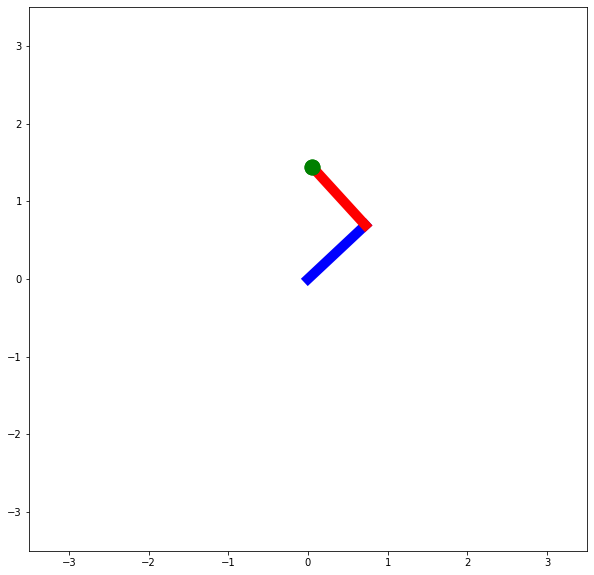

In [4]:
N = 4000
L1 = 1
L2 = 1
q1 = np.linspace(0, np.pi/4, N)
q2 = np.linspace(0, np.pi/2, N)

q = np.zeros((N, 2))
q[:, 0] = q1
q[:, 1] = q2

anim = plot_planar_manipulator(q, L1, L2)
HTML(anim.to_html5_video())


# Q2 Build Jacobian 



Calculate the Jacobian:

$$
\begin{pmatrix}
\dot{x} \\
\dot{y} \\
\dot{\theta} \\
\end{pmatrix} =
\begin{pmatrix}
\frac{d x}{d q_0} & 
\frac{d x}{d q_1} \\
\frac{d y}{d q_0} & 
\frac{d y}{d q_1}  
\end{pmatrix}
\begin{pmatrix}
\dot{q_0} \\
\dot{q_1} 
\end{pmatrix}
$$
> Find the partial derivatives and fill in the Jacobian matrix below (take the derivative of the end effector position $x, y, \theta$ with respect to time, then take derivatives w.r.t. joint position coordinates $q_0, q_1, q_2$ 

In [5]:
#@title Default title text
# Returns a function that can be used to get jacobian at the current state
def build_jacobian(l1=1, l2=1):
    
    # 
    def evaluate_jacobian(q):
        # Use these variables and the link lengths in function def
        q0, q1 = q

        J = [[], []]

        J[0] = [-l1*np.sin(q0)-l2*np.sin(q0+q1), -l2*np.sin(q0+q1)] # Your answers here
        J[1] = [l1*np.cos(q0)+l2*np.cos(q0+q1), l2*np.cos(q0+q1)] # Your answers here

        return np.array(J)

    return evaluate_jacobian

# From now on use the function below to evaluate jacobian at a given state
L1 = 1
L2 = 1
jacobian = build_jacobian(L1, L2)
print(jacobian([0, 0]))

[[-0. -0.]
 [ 2.  1.]]


In [6]:
print(jacobian([0, 0]))
print(jacobian([np.pi/2, 0]))
print(jacobian([0, np.pi/2]))

[[-0. -0.]
 [ 2.  1.]]
[[-2.0000000e+00 -1.0000000e+00]
 [ 1.2246468e-16  6.1232340e-17]]
[[-1.000000e+00 -1.000000e+00]
 [ 1.000000e+00  6.123234e-17]]


#Q3 Newton-Raphson Method

[1.19625523 1.19117079]
50
50


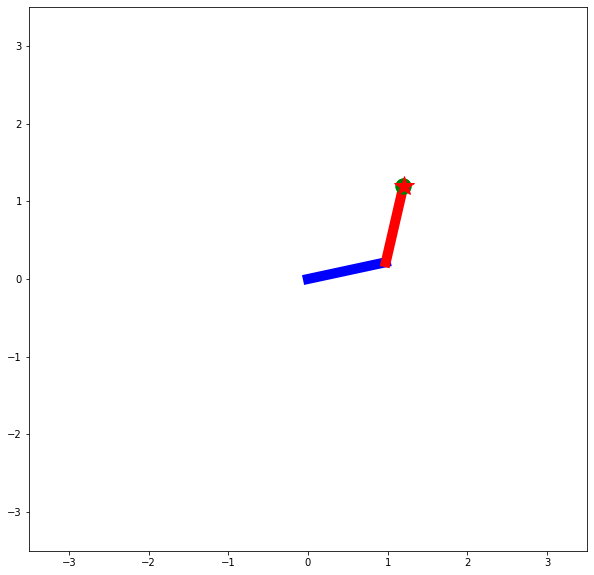

In [8]:
# array to hold joint position iterations
q_anim = []

# Choose an initial guess for joint position,
qi = np.array([0.0, 0.0]) 
q_anim += [qi.copy()]

# Goal position
x_goal = np.array([1.2, 1.2])

# Compute error between goal and current EE position
d_x = x_goal - forward_kinematics(qi)

# Small value at which we stop iterating if the error is smaller
epsilon = 0.01
step_size = 0.1
iter = 0 
while np.linalg.norm(d_x) > epsilon and iter < 100:
   # Your code here (complete Newton Rapson)

   # Get Jacobian at current joint position
   J = jacobian(qi)

   # Get Jacobian psuedo-inverse
   J_I = np.linalg.pinv(J)

   # Get Jacobian psuedo-inverse tranpose
   J_IT = np.transpose(np.linalg.pinv(J))

   # Compute change in joint position using corresponding
   #  change in EE position
   d_q = np.matmul(J_I, d_x)

   # Update joint position
   qi = qi + step_size*d_q
   q_anim += [qi.copy()]

   # Update error between goal and current EE position
   d_x = x_goal - forward_kinematics(qi)
   iter += 1

print(forward_kinematics(qi))
anim = plot_planar_manipulator(np.array(q_anim), L1, L2,target=x_goal, interval= 1)
HTML(anim.to_html5_video())


